<a href="https://colab.research.google.com/github/kannanarora/A3-social-media-and-network-analytics/blob/main/graph_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reddit Reply Graph + Centrality

In [ ]:
import json
with open("/content/drive/MyDrive/Assignment_2_Social_Media/youtube_comments.json", "r", encoding="utf-8") as f:
    youtube_data = json.load(f)
with open("/content/drive/MyDrive/Assignment_2_Social_Media/reddit_data.json", "r", encoding="utf-8") as f:
    reddit_data = json.load(f)


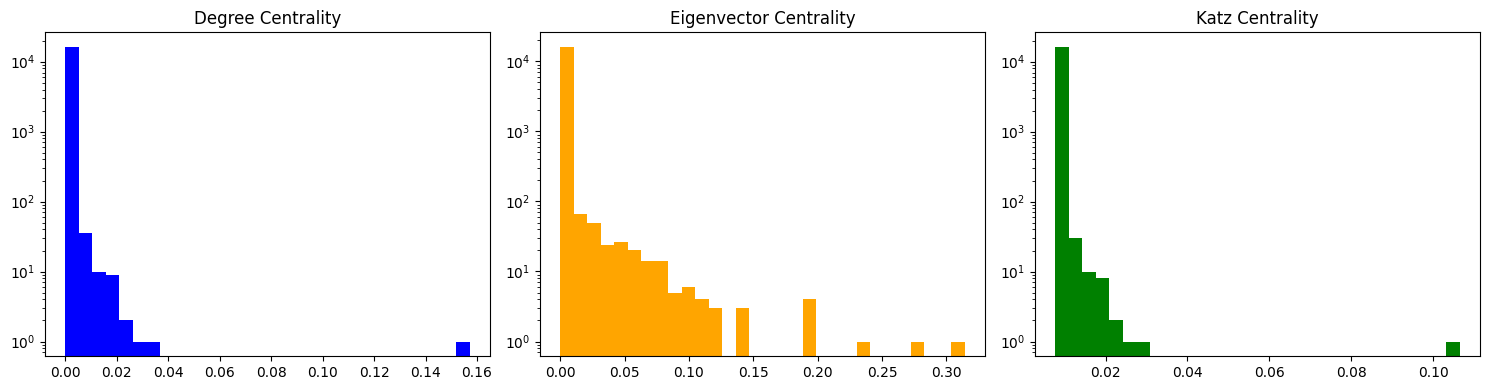


Network Metrics:
Nodes: 16230
Edges: 24346
Transitivity: 0.02047155454564406
Strongly Connected Components: 16073
Weakly Connected Components: 14


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import json

# Load Reddit Data
with open("/content/drive/MyDrive/Assignment_2_Social_Media/reddit_data.json", "r", encoding="utf-8") as f:
    reddit_data = json.load(f)

# reply graph
replyGraph = nx.DiGraph()
post_authors = {}


for entry in reddit_data:
    if entry["type"] == "post":
        post_authors[entry["id"]] = entry.get("author", "unknown")

# add edges
for entry in reddit_data:
    if entry["type"] == "comment":
        comment_author = entry.get("author", "unknown")
        parent_id = entry.get("parent_id", "")
        parent_author = post_authors.get(parent_id, "unknown")

        if comment_author != parent_author and "unknown" not in (comment_author, parent_author):
            if replyGraph.has_edge(comment_author, parent_author):
                replyGraph[comment_author][parent_author]["replyNum"] += 1
            else:
                replyGraph.add_edge(comment_author, parent_author, replyNum=1)

# centrality Measures
deg_cent = nx.degree_centrality(replyGraph)
eigen_cent = nx.eigenvector_centrality(replyGraph, max_iter=1000)
katz_cent = nx.katz_centrality(replyGraph, alpha=0.005)

for node in replyGraph.nodes():
    replyGraph.nodes[node]["deg"] = deg_cent.get(node, 0)
    replyGraph.nodes[node]["eigen"] = eigen_cent.get(node, 0)
    replyGraph.nodes[node]["katz"] = katz_cent.get(node, 0)

# Visualize Centralities
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(list(deg_cent.values()), bins=30, color='blue', log=True)
plt.title("Degree Centrality")

plt.subplot(1, 3, 2)
plt.hist(list(eigen_cent.values()), bins=30, color='orange', log=True)
plt.title("Eigenvector Centrality")

plt.subplot(1, 3, 3)
plt.hist(list(katz_cent.values()), bins=30, color='green', log=True)
plt.title("Katz Centrality")

plt.tight_layout()
plt.show()

# Network Metrics
print("\nNetwork Metrics:")
print("Nodes:", len(replyGraph))
print("Edges:", replyGraph.size())
print("Transitivity:", nx.transitivity(replyGraph))
print("Strongly Connected Components:", nx.number_strongly_connected_components(replyGraph))
print("Weakly Connected Components:", nx.number_weakly_connected_components(replyGraph))


## Youtube Co-commenter Graph + Centrality

In [ ]:
G_youtube = nx.Graph()

for video in youtube_data:
    commenters = set(c["author"] for c in video["comments"] if c.get("author"))
    for u1 in commenters:
        for u2 in commenters:
            if u1 != u2:
                if G_youtube.has_edge(u1, u2):
                    G_youtube[u1][u2]['weight'] += 1
                else:
                    G_youtube.add_edge(u1, u2, weight=1)


In [ ]:
deg_cent_yt = nx.degree_centrality(G_youtube)
for node in G_youtube.nodes():
    G_youtube.nodes[node]["deg"] = deg_cent_yt.get(node, 0)


In [ ]:
# Filter to top 500 users by degree
top_users = sorted(deg_cent_yt.items(), key=lambda x: x[1], reverse=True)[:500]
top_nodes = {u[0] for u in top_users}
G_small = G_youtube.subgraph(top_nodes).copy()

# eigen/Katz on the smaller graph
eigen_cent_yt = nx.eigenvector_centrality(G_small, max_iter=1000)
katz_cent_yt = nx.katz_centrality(G_small, alpha=0.001, max_iter=2000)



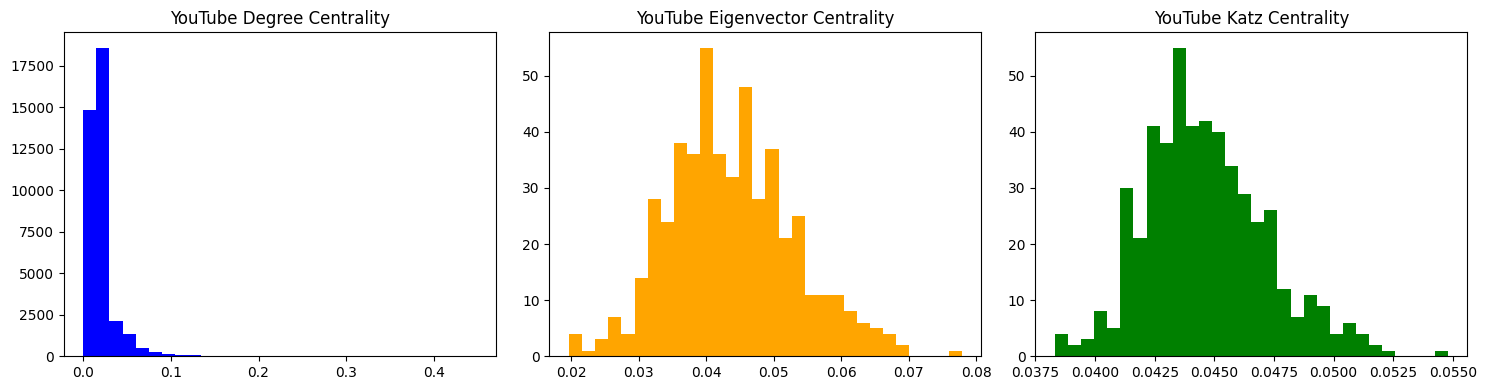

In [ ]:
# Visualize Centralities
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(deg_cent_yt.values(), bins=30, color='blue')
plt.title("YouTube Degree Centrality")

plt.subplot(1, 3, 2)
plt.hist(eigen_cent_yt.values(), bins=30, color='orange')
plt.title("YouTube Eigenvector Centrality")

plt.subplot(1, 3, 3)
plt.hist(katz_cent_yt.values(), bins=30, color='green')
plt.title("YouTube Katz Centrality")

plt.tight_layout()
plt.show()


## Reddit Egonet Construction

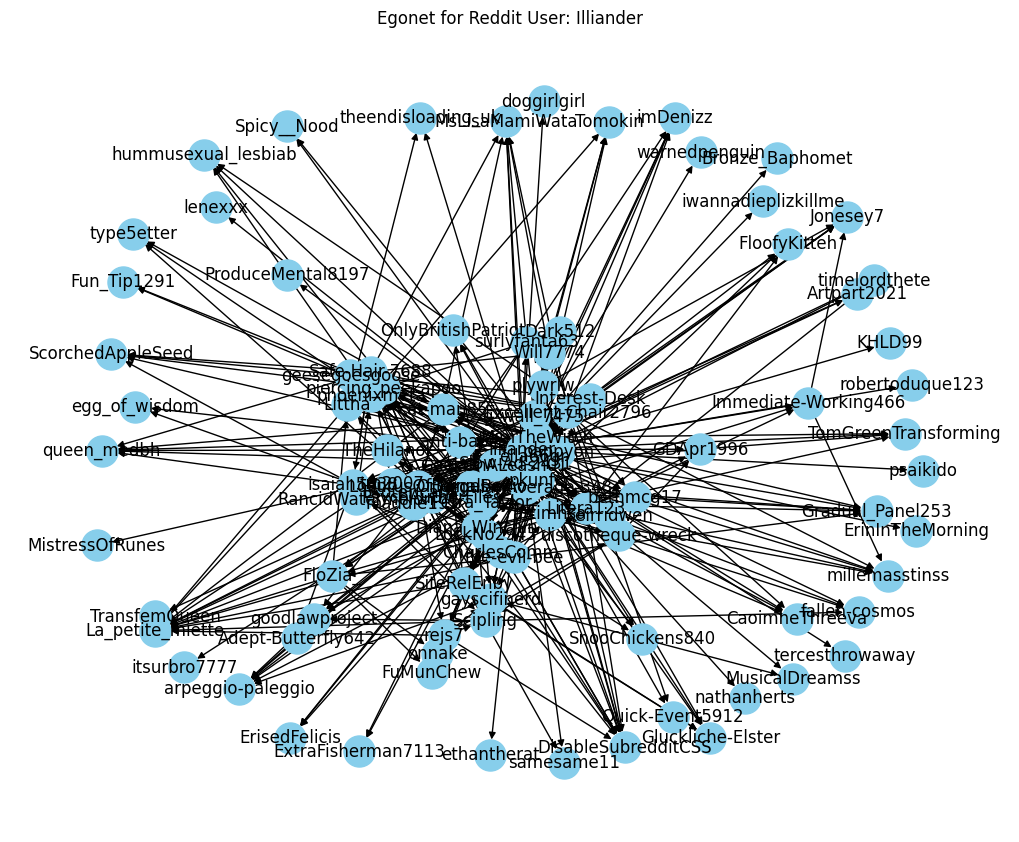

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx

# post to author mapping
post_authors = {
    entry["id"]: entry.get("author", "unknown")
    for entry in reddit_data
    if entry["type"] == "post" and "author" in entry
}

# comment to author mapping
comment_authors = {
    entry["id"]: entry.get("author", "unknown")
    for entry in reddit_data
    if entry["type"] == "comment" and "author" in entry
}

# Find top Reddit commenter
author_counts = Counter(
    entry["author"] for entry in reddit_data
    if entry["type"] == "comment"
    and entry.get("author")
    and entry["author"] not in ("unknown", "AutoModerator")
)

ego = author_counts.most_common(1)[0][0]

# egonet
egoGraph = nx.DiGraph()
egoGraph.add_node(ego)

# sets for faster lookup
ego_neighbors = set()

# first pass (add ego to alter edges)
for entry in reddit_data:
    if entry["type"] == "comment" and entry.get("author") and entry.get("parent_id"):
        parent_id = entry["parent_id"].split("_")[-1]
        parent_author = post_authors.get(parent_id) or comment_authors.get(parent_id)

        if entry["author"] == ego:
            if parent_author and parent_author != ego:
                egoGraph.add_node(parent_author)
                egoGraph.add_edge(ego, parent_author)
                ego_neighbors.add(parent_author)

        elif parent_author == ego:
            author = entry["author"]
            if author != ego:
                egoGraph.add_node(author)
                egoGraph.add_edge(author, ego)
                ego_neighbors.add(author)

# second pass (add alter to alter edges if both are in ego_neighbors)
for entry in reddit_data:
    if entry["type"] == "comment" and entry.get("author") and entry.get("parent_id"):
        author = entry["author"]
        parent_id = entry["parent_id"].split("_")[-1]
        parent_author = post_authors.get(parent_id) or comment_authors.get(parent_id)

        if author in ego_neighbors and parent_author in ego_neighbors and author != parent_author:
            egoGraph.add_edge(author, parent_author)

# egonet visualisation
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(egoGraph, seed=42)
nx.draw(egoGraph, pos, with_labels=True, node_size=500, node_color='skyblue', arrows=True)
plt.title(f"Egonet for Reddit User: {ego}")
plt.axis('off')
plt.show()


In [ ]:
print("Top commenter (ego):", ego)

Top commenter (ego): Illiander


## Reddit Community

<ipython-input-16-0336376fc4f7>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(dLouvainComms.values()) + 1)


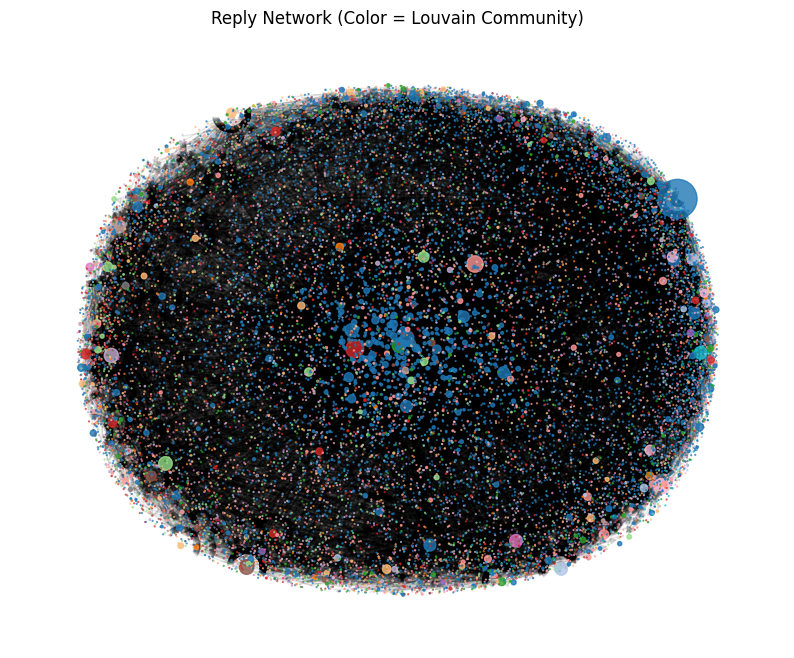

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import community.community_louvain as community_louvain

# Louvain community detection
G_undirected = replyGraph.to_undirected()
dLouvainComms = community_louvain.best_partition(G_undirected)

# assign community to each node
for node, comm_id in dLouvainComms.items():
    replyGraph.nodes[node]['louvain'] = comm_id

# layout and node sizes
pos = nx.spring_layout(replyGraph, k=0.15, seed=42)
deg_cent = nx.degree_centrality(replyGraph)
node_sizes = [deg_cent.get(n, 0) * 5000 for n in replyGraph.nodes()]
node_colors = [dLouvainComms.get(n, 0) for n in replyGraph.nodes()]
cmap = plt.cm.get_cmap("tab20", max(dLouvainComms.values()) + 1)

# plot network
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(replyGraph, pos,
                       node_size=node_sizes,
                       alpha=0.8,
                       node_color=node_colors,
                       cmap=cmap)
nx.draw_networkx_edges(replyGraph, pos, alpha=0.1, arrowsize=10)
plt.title("Reply Network (Color = Louvain Community)")
plt.axis('off')
plt.show()


In [ ]:
print("Average Clustering:", nx.average_clustering(G_undirected))

# top Nodes Analysis
print("\nTop 5 Nodes by Degree Centrality:")
top_nodes = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
for node, score in top_nodes:
    print(f"{node}: Degree={score:.4f}, Community={replyGraph.nodes[node]['louvain']}")

Average Clustering: 0.014619105803948143

Top 5 Nodes by Degree Centrality:
CummingInTheNile: Degree=0.1572, Community=0
Safe-Hair-7688: Degree=0.0333, Community=14
onnake: Degree=0.0279, Community=17
TreKeyz: Degree=0.0243, Community=31
Ok_Archer1228: Degree=0.0218, Community=24


<ipython-input-18-c3abfbce6c7b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(comms)+1)


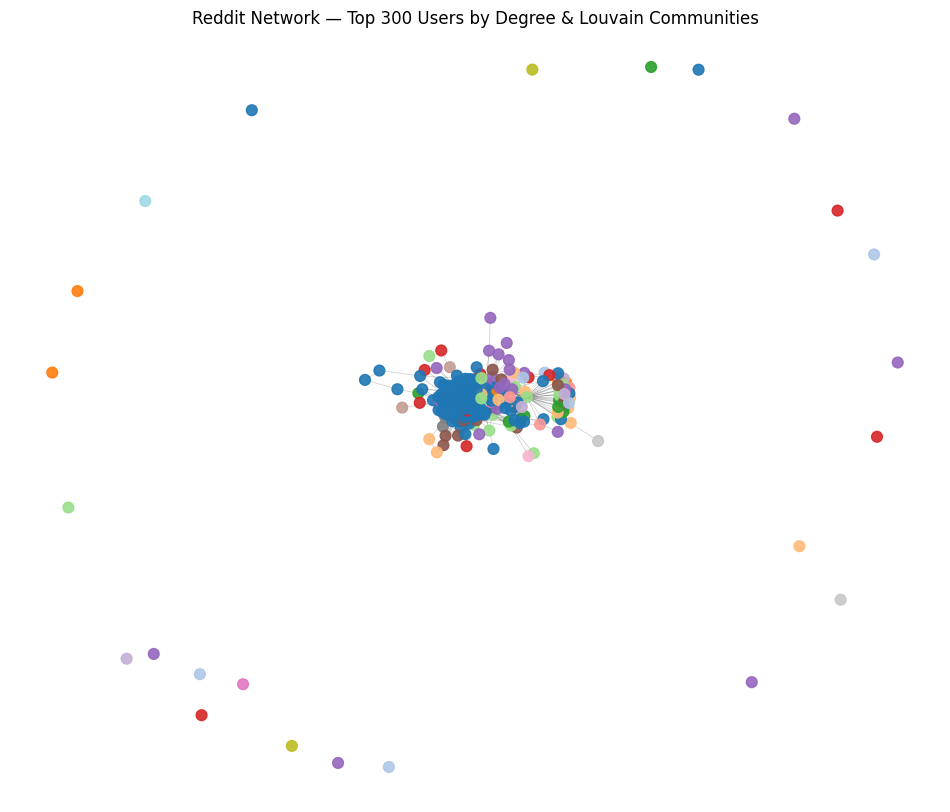

In [ ]:
# filter to top 300 nodes by degree
top_nodes = sorted(G_undirected.degree(), key=lambda x: x[1], reverse=True)[:300]
top_node_set = [node for node, _ in top_nodes]
G_small = G_undirected.subgraph(top_node_set).copy()

# Louvain community list and layout
comms = [dLouvainComms.get(n, -1) for n in G_small.nodes()]
pos = nx.spring_layout(G_small, seed=42)
cmap = plt.cm.get_cmap('tab20', max(comms)+1)

# plot reduced community graph
plt.figure(figsize=(12,10))
nx.draw_networkx_nodes(
    G_small, pos,
    node_size=60,
    node_color=comms,
    cmap=cmap,
    alpha=0.9
)
nx.draw_networkx_edges(G_small, pos, alpha=0.2, width=0.5)
plt.title("Reddit Network — Top 300 Users by Degree & Louvain Communities")
plt.axis('off')
plt.show()


In [ ]:
# add community and degree to each node in G_small
for node in G_small.nodes():
    G_small.nodes[node]['community'] = dLouvainComms.get(node, -1)
    G_small.nodes[node]['degree_centrality'] = deg_cent.get(node, 0)

# top 5 users
top_node_names = [node for node, _ in top_nodes[:5]]
for node in G_small.nodes():
    G_small.nodes[node]['top_5'] = 'yes' if node in top_node_names else 'no'

nx.write_graphml(G_small, "reddit_top300.graphml", infer_numeric_types=True)
from google.colab import files
files.download("reddit_top300.graphml")


In [ ]:
# Count users per community in G_small
from collections import Counter

comm_counts = Counter([dLouvainComms[n] for n in G_small.nodes()])
top_comms = comm_counts.most_common(3)
print("Top communities by size:", top_comms)

for comm_id, size in top_comms:
    nodes_in_comm = [n for n in G_small.nodes() if dLouvainComms[n] == comm_id]
    subgraph = G_small.subgraph(nodes_in_comm).copy()

    # add node attributes
    for node in subgraph.nodes():
        subgraph.nodes[node]['community'] = comm_id
        subgraph.nodes[node]['degree_centrality'] = deg_cent.get(node, 0)
        subgraph.nodes[node]['top_5'] = 'yes' if node in top_node_names else 'no'

    # export to Gephi
    filename = f"reddit_comm_{comm_id}.graphml"
    nx.write_graphml(subgraph, filename, infer_numeric_types=True)
    from google.colab import files
    files.download(filename)


Top communities by size: [(2, 154), (1, 18), (17, 13)]


In [ ]:
# load YouTube data and extract top commente
import json
from collections import Counter

with open("/content/drive/MyDrive/Assignment_2_Social_Media/youtube_comments.json", "r", encoding="utf-8") as f:
    youtube_data = json.load(f)

comment_authors = []
for video in youtube_data:
    for comment in video.get("comments", []):
        author = comment.get("author")
        if author and author.lower() != "unknown":
            comment_authors.append(author)

author_counts = Counter(comment_authors)
ego = author_counts.most_common(1)[0][0]
print("Top YouTube commenter (ego):", ego)

Top YouTube commenter (ego): @hospitalsgivingpatientsdan8894


In [ ]:
# co-commenter graph
import networkx as nx

G_youtube = nx.Graph()
for video in youtube_data:
    commenters = set(c["author"] for c in video["comments"] if c.get("author"))
    for u1 in commenters:
        for u2 in commenters:
            if u1 != u2:
                if G_youtube.has_edge(u1, u2):
                    G_youtube[u1][u2]["weight"] += 1
                else:
                    G_youtube.add_edge(u1, u2, weight=1)



In [ ]:
# Louvain Community Detection
import community.community_louvain as community_louvain

dLouvainYT = community_louvain.best_partition(G_youtube)
for node, comm_id in dLouvainYT.items():
    G_youtube.nodes[node]['community'] = comm_id

In [ ]:
# centrality computation

deg_cent_yt = nx.degree_centrality(G_youtube)
for node in G_youtube.nodes():
    G_youtube.nodes[node]['degree_centrality'] = deg_cent_yt.get(node, 0)

top_nodes_yt = sorted(deg_cent_yt.items(), key=lambda x: x[1], reverse=True)[:300]
top_node_set_yt = [node for node, _ in top_nodes_yt]
G_small_yt = G_youtube.subgraph(top_node_set_yt).copy()

# label top 5 nodes
top_node_names_yt = [node for node, _ in top_nodes_yt[:5]]
for node in G_small_yt.nodes():
    G_small_yt.nodes[node]['top_5'] = 'yes' if node in top_node_names_yt else 'no'




<ipython-input-25-2c8ad34be9ac>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(comms_yt)+1)


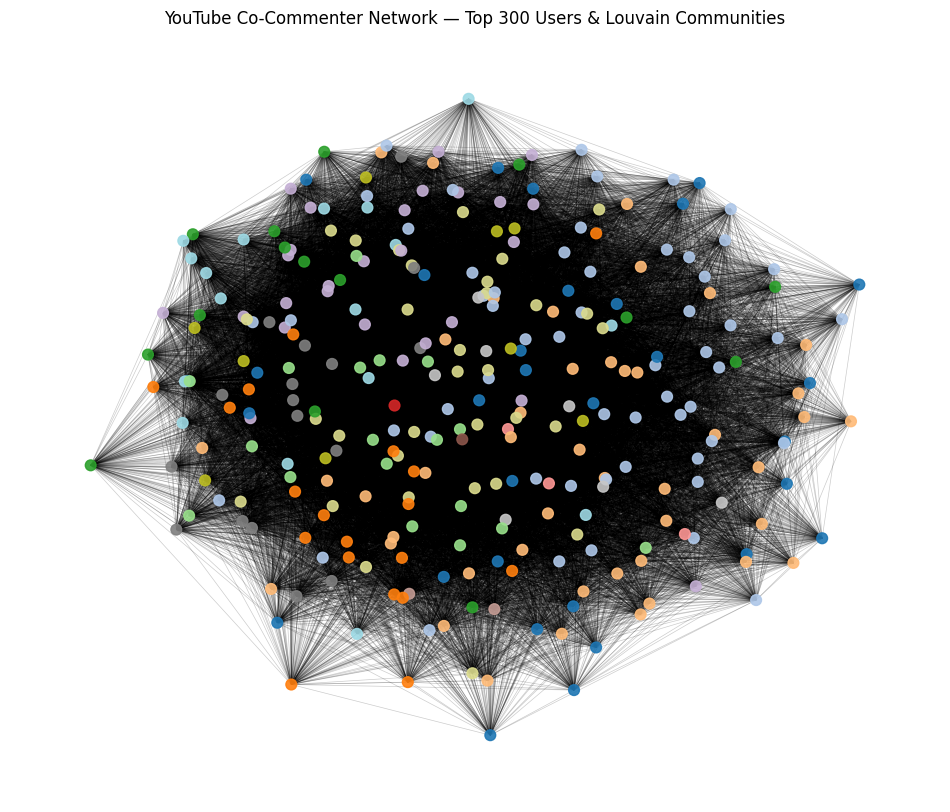

In [ ]:
# reduced graph (Top 300) visualisation

import matplotlib.pyplot as plt
import matplotlib.cm as cm

comms_yt = [dLouvainYT.get(n, -1) for n in G_small_yt.nodes()]
pos = nx.spring_layout(G_small_yt, seed=42)
cmap = plt.cm.get_cmap('tab20', max(comms_yt)+1)

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G_small_yt, pos, node_size=60, node_color=comms_yt, cmap=cmap, alpha=0.9)
nx.draw_networkx_edges(G_small_yt, pos, alpha=0.2, width=0.5)
plt.title("YouTube Co-Commenter Network — Top 300 Users & Louvain Communities")
plt.axis('off')
plt.show()


In [ ]:
# export Top Communities
from collections import Counter
from google.colab import files

comm_counts_yt = Counter([dLouvainYT[n] for n in G_small_yt.nodes()])
top_comms_yt = comm_counts_yt.most_common(3)
print("Top YouTube communities by size:", top_comms_yt)

for comm_id, size in top_comms_yt:
    nodes_in_comm = [n for n in G_small_yt.nodes() if dLouvainYT[n] == comm_id]
    subgraph = G_small_yt.subgraph(nodes_in_comm).copy()

    for node in subgraph.nodes():
        subgraph.nodes[node]['community'] = comm_id
        subgraph.nodes[node]['degree_centrality'] = deg_cent_yt.get(node, 0)
        subgraph.nodes[node]['top_5'] = 'yes' if node in top_node_names_yt else 'no'

    filename = f"youtube_comm_{comm_id}.graphml"
    nx.write_graphml(subgraph, filename, infer_numeric_types=True)
    files.download(filename)


Top YouTube communities by size: [(3, 33), (7, 27), (19, 26)]


## Youtube Egonet Construction

Top YouTube commenter (ego): @hospitalsgivingpatientsdan8894


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4624 (\N{ETHIOPIC SYLLABLE HHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4704 (\N{ETHIOPIC SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4667 (\N{ETHIOPIC SYLLABLE SHAA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


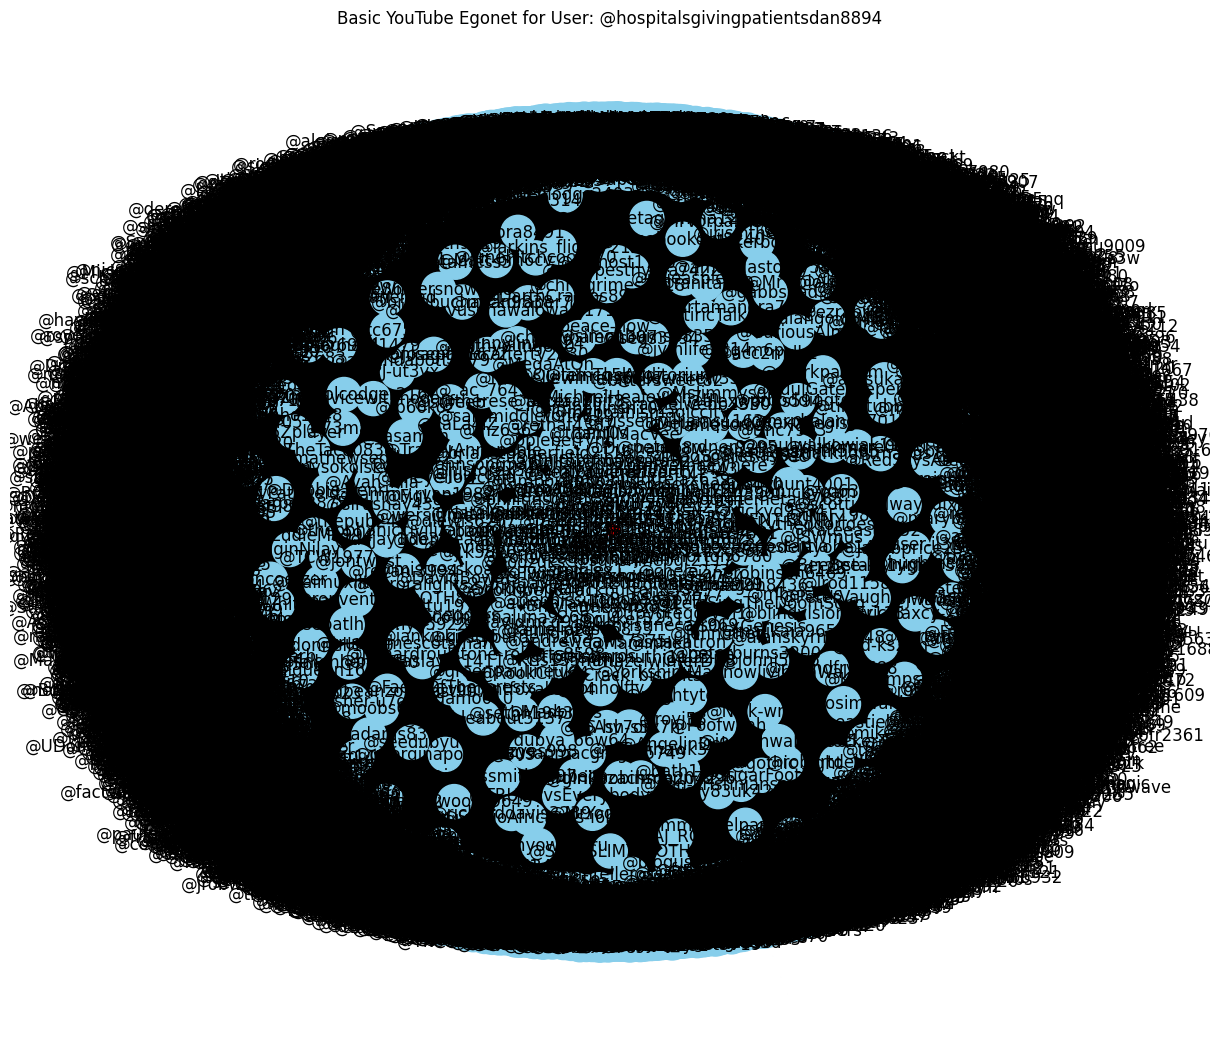

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

# load youTube data
with open("/content/drive/MyDrive/Assignment_2_Social_Media/youtube_comments.json", "r", encoding="utf-8") as f:
    youtube_data = json.load(f)

# count comment authors
comment_authors = []

for video in youtube_data:
    for comment in video.get("comments", []):
        author = comment.get("author")
        if author and author.lower() != "unknown":
            comment_authors.append(author)

author_counts = Counter(comment_authors)
ego = author_counts.most_common(1)[0][0]
print("Top YouTube commenter (ego):", ego)

# build basic egonet
yt_basic_egoGraph = nx.DiGraph()
yt_basic_egoGraph.add_node(ego)

for video in youtube_data:
    video_authors = {c.get("author") for c in video["comments"] if c.get("author")}

    if ego in video_authors:
        for author in video_authors:
            if author and author != ego:
                yt_basic_egoGraph.add_node(author)
                yt_basic_egoGraph.add_edge(ego, author)

# visualize the egonet
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(yt_basic_egoGraph, seed=42)
node_colors = ['red' if node == ego else 'skyblue' for node in yt_basic_egoGraph.nodes()]
nx.draw(yt_basic_egoGraph, pos, with_labels=True, node_size=600, node_color=node_colors, arrows=True)
plt.title(f"Basic YouTube Egonet for User: {ego}")
plt.axis('off')
plt.show()

# export for Gephi
nx.write_graphml(yt_basic_egoGraph, "youtube_egonet_basic.graphml", infer_numeric_types=True)

from google.colab import files
files.download("youtube_egonet_basic.graphml")


In [ ]:
import json
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import files
import gc

# load YouTube Data
with open("/content/drive/MyDrive/Assignment_2_Social_Media/youtube_comments.json", "r", encoding="utf-8") as f:
    youtube_data = json.load(f)

# count comment authors
comment_authors = []

for video in youtube_data:
    for comment in video.get("comments", []):
        author = comment.get("author")
        if author and author.lower() != "unknown":
            comment_authors.append(author)

author_counts = Counter(comment_authors)
ego = author_counts.most_common(1)[0][0]
print("Top YouTube commenter (ego):", ego)

# build Basic Egonet
yt_basic_egoGraph = nx.DiGraph()
yt_basic_egoGraph.add_node(ego)

MAX_USERS_PER_VIDEO = 100  # to limit performance hit

for video in youtube_data:
    comments = video.get("comments", [])

    # skip extremely large comment sets
    if len(comments) > 1000:
        continue

    video_authors = {c.get("author") for c in comments if c.get("author")}
    video_authors = set(list(video_authors)[:MAX_USERS_PER_VIDEO])

    if ego in video_authors:
        for author in video_authors:
            if author and author != ego:
                yt_basic_egoGraph.add_node(author)
                yt_basic_egoGraph.add_edge(ego, author)

# print graph size
print("Total nodes:", len(yt_basic_egoGraph.nodes()))
print("Total edges:", len(yt_basic_egoGraph.edges()))

# egonet visualisation
if len(yt_basic_egoGraph.nodes()) <= 200:
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(yt_basic_egoGraph, seed=42)
    node_colors = ['red' if node == ego else 'skyblue' for node in yt_basic_egoGraph.nodes()]
    nx.draw(yt_basic_egoGraph, pos, with_labels=True, node_size=600, node_color=node_colors, arrows=True)
    plt.title(f"Basic YouTube Egonet for User: {ego}")
    plt.axis('off')
    plt.show()
else:
    print("Skipping visualization: graph too large.")

# export for Gephi
try:
    nx.write_graphml(yt_basic_egoGraph, "youtube_egonet_basic.graphml", infer_numeric_types=True)
    files.download("youtube_egonet_basic.graphml")
except Exception as e:
    print(f"Export failed: {e}")

gc.collect()


Top YouTube commenter (ego): @hospitalsgivingpatientsdan8894
Total nodes: 1700
Total edges: 1699
Skipping visualization: graph too large.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

17048